# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Develop a predictive model to identify the key factors that drive the price of used cars. By analyzing a dataset of used cars, we aim to uncover the relationships between various attributes, such as make, model, year, mileage, condition, and features, and their impact on car prices, ultimately informing data-driven recommendations for used car dealerships.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.tree import _tree, plot_tree

In [33]:
# load the dataset
file_path = 'data/vehicles.csv'
data = pd.read_csv(file_path)

In [34]:
# dataset sample
data_sample = data.tail()
print(data_sample)

                id   region  price    year manufacturer  \
426875  7301591192  wyoming  23590  2019.0       nissan   
426876  7301591187  wyoming  30590  2020.0        volvo   
426877  7301591147  wyoming  34990  2020.0     cadillac   
426878  7301591140  wyoming  28990  2018.0        lexus   
426879  7301591129  wyoming  30590  2019.0          bmw   

                           model condition    cylinders    fuel  odometer  \
426875         maxima s sedan 4d      good  6 cylinders     gas   32226.0   
426876  s60 t5 momentum sedan 4d      good          NaN     gas   12029.0   
426877          xt4 sport suv 4d      good          NaN  diesel    4174.0   
426878           es 350 sedan 4d      good  6 cylinders     gas   30112.0   
426879  4 series 430i gran coupe      good          NaN     gas   22716.0   

       title_status transmission                VIN drive size       type  \
426875        clean        other  1N4AA6AV6KC367801   fwd  NaN      sedan   
426876        clean        o

In [35]:
# check for missing values
missing_values = data.isnull().mean() * 100
missing_values_sorted = missing_values.sort_values(ascending=False)
print("\nPercentage of missing values:")
print(missing_values_sorted)


Percentage of missing values:
size            71.767476
cylinders       41.622470
condition       40.785232
VIN             37.725356
drive           30.586347
paint_color     30.501078
type            21.752717
manufacturer     4.133714
title_status     1.930753
model            1.236179
odometer         1.030735
fuel             0.705819
transmission     0.598763
year             0.282281
id               0.000000
region           0.000000
price            0.000000
state            0.000000
dtype: float64


In [36]:
# summary statistics for numerical columns
numerical_summary = data.describe()
print("\nSummary statistics for numerical columns:")
print(numerical_summary)


Summary statistics for numerical columns:
                 id         price           year      odometer
count  4.268800e+05  4.268800e+05  425675.000000  4.224800e+05
mean   7.311487e+09  7.519903e+04    2011.235191  9.804333e+04
std    4.473170e+06  1.218228e+07       9.452120  2.138815e+05
min    7.207408e+09  0.000000e+00    1900.000000  0.000000e+00
25%    7.308143e+09  5.900000e+03    2008.000000  3.770400e+04
50%    7.312621e+09  1.395000e+04    2013.000000  8.554800e+04
75%    7.315254e+09  2.648575e+04    2017.000000  1.335425e+05
max    7.317101e+09  3.736929e+09    2022.000000  1.000000e+07


Price: the average price is quite high at &#36;75,199, but the median is &#36;13,950, suggesting a skewed distribution with a few very expensive outliers. The minimum price is 0, which might indicate errors or missing data.

Year: the vehicles range from 1900 to 2022, with a median year of 2013. The presence of 1900 as a minimum is likely due to data entry errors.

Odometer: the average mileage is around 98,043 miles, with some entries at 0, which might again indicate missing or incorrect data. The maximum value (10 million miles) is also likely erroneous.

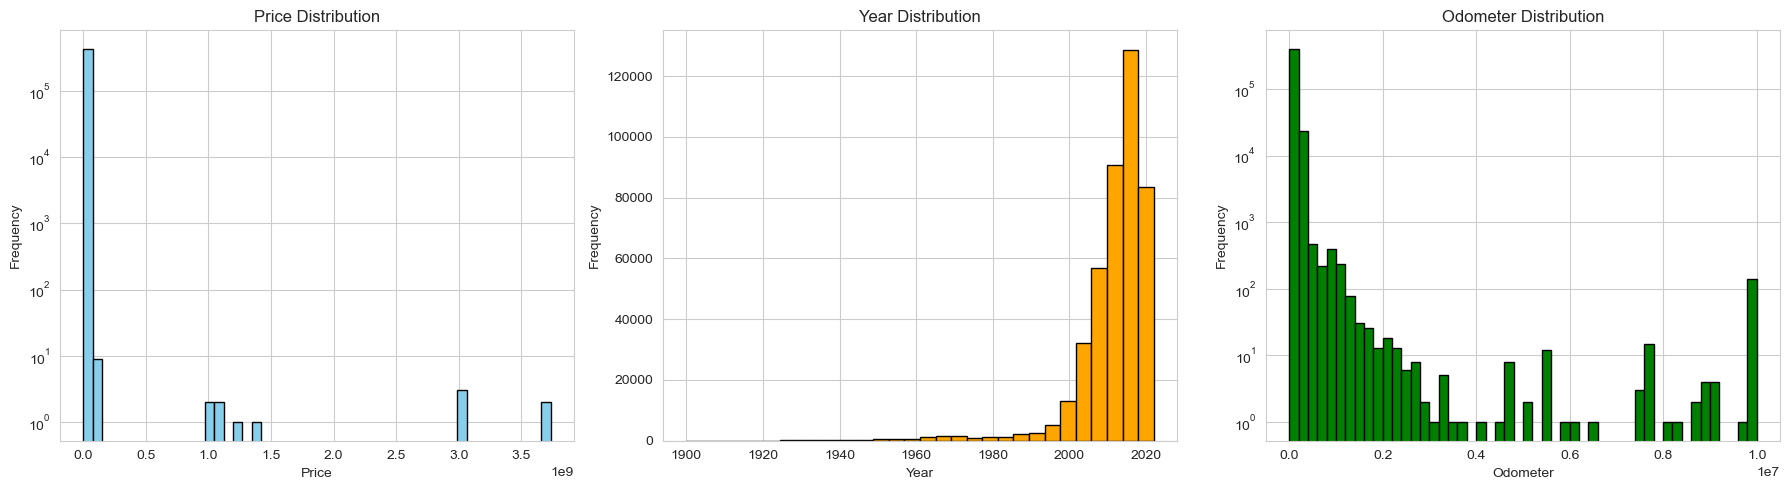

In [37]:
# visualize the distribution of key variables
plt.figure(figsize=(18, 5))

# price distribution
plt.subplot(1, 3, 1)
plt.hist(data['price'], bins=50, color='skyblue', edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.yscale('log')  # Log scale due to skewness

# year distribution
plt.subplot(1, 3, 2)
plt.hist(data['year'].dropna(), bins=30, color='orange', edgecolor='black')
plt.title('Year Distribution')
plt.xlabel('Year')
plt.ylabel('Frequency')

# odometer distribution
plt.subplot(1, 3, 3)
plt.hist(data['odometer'].dropna(), bins=50, color='green', edgecolor='black')
plt.title('Odometer Distribution')
plt.xlabel('Odometer')
plt.ylabel('Frequency')
plt.yscale('log')  # Log scale due to skewness

plt.tight_layout()
plt.show()

Price Distribution: the price distribution is heavily skewed to the right, with a large number of cars priced below &#36;30,000. The log scale on the y-axis reveals a long tail with fewer expensive cars, indicating the presence of significant outliers. There are also records where price is zero, which, I assume, are errors.

Year Distribution: most cars are relatively recent, with the majority manufactured between 2000 and 2020. The distribution peaks around 2013, aligning with the median year from the summary statistics. There are a few entries for cars made before 1950, which could be rare vintage models or errors.

Odometer Distribution: The odometer readings are also skewed, with most cars having less than 200,000 miles. The log scale shows that a few cars have unusually high mileage, possibly indicating errors.

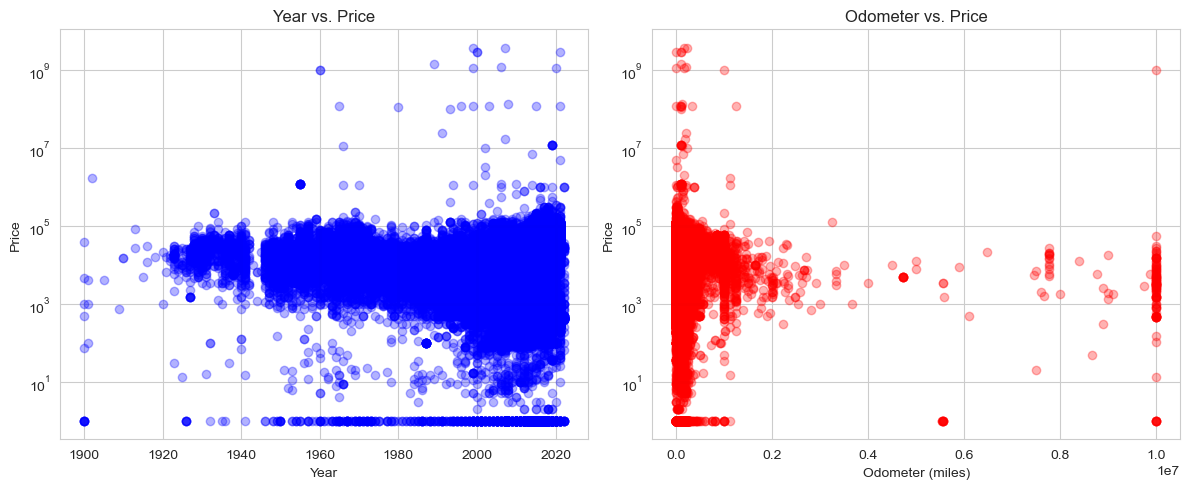

In [38]:
# scatter plots to explore relationships between variables
plt.figure(figsize=(12, 5))

# Year and Price
plt.subplot(1, 2, 1)
plt.scatter(data['year'], data['price'], alpha=0.3, color='blue')
plt.title('Year vs. Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.yscale('log')  # Log scale for better visualization

# Odometer and Price
plt.subplot(1, 2, 2)
plt.scatter(data['odometer'], data['price'], alpha=0.3, color='red')
plt.title('Odometer vs. Price')
plt.xlabel('Odometer (miles)')
plt.ylabel('Price')
plt.yscale('log')  # Log scale for better visualization

plt.tight_layout()
plt.show()

Year vs. Price: there is a general trend where newer cars (more recent years) tend to have higher prices. However, there are outliers with both high and low prices across different years. The older cars, especially those before the 2000s, generally show lower prices, with some exceptions possibly due to vintage or collector value.

Odometer vs. Price: ss expected, cars with lower mileage (odometer readings) tend to have higher prices. There’s a clear downward trend indicating that as the odometer reading increases, the car’s price decreases. Again, there are a few outliers with high prices even at high mileage, which might be due to unique vehicle attributes or errors.

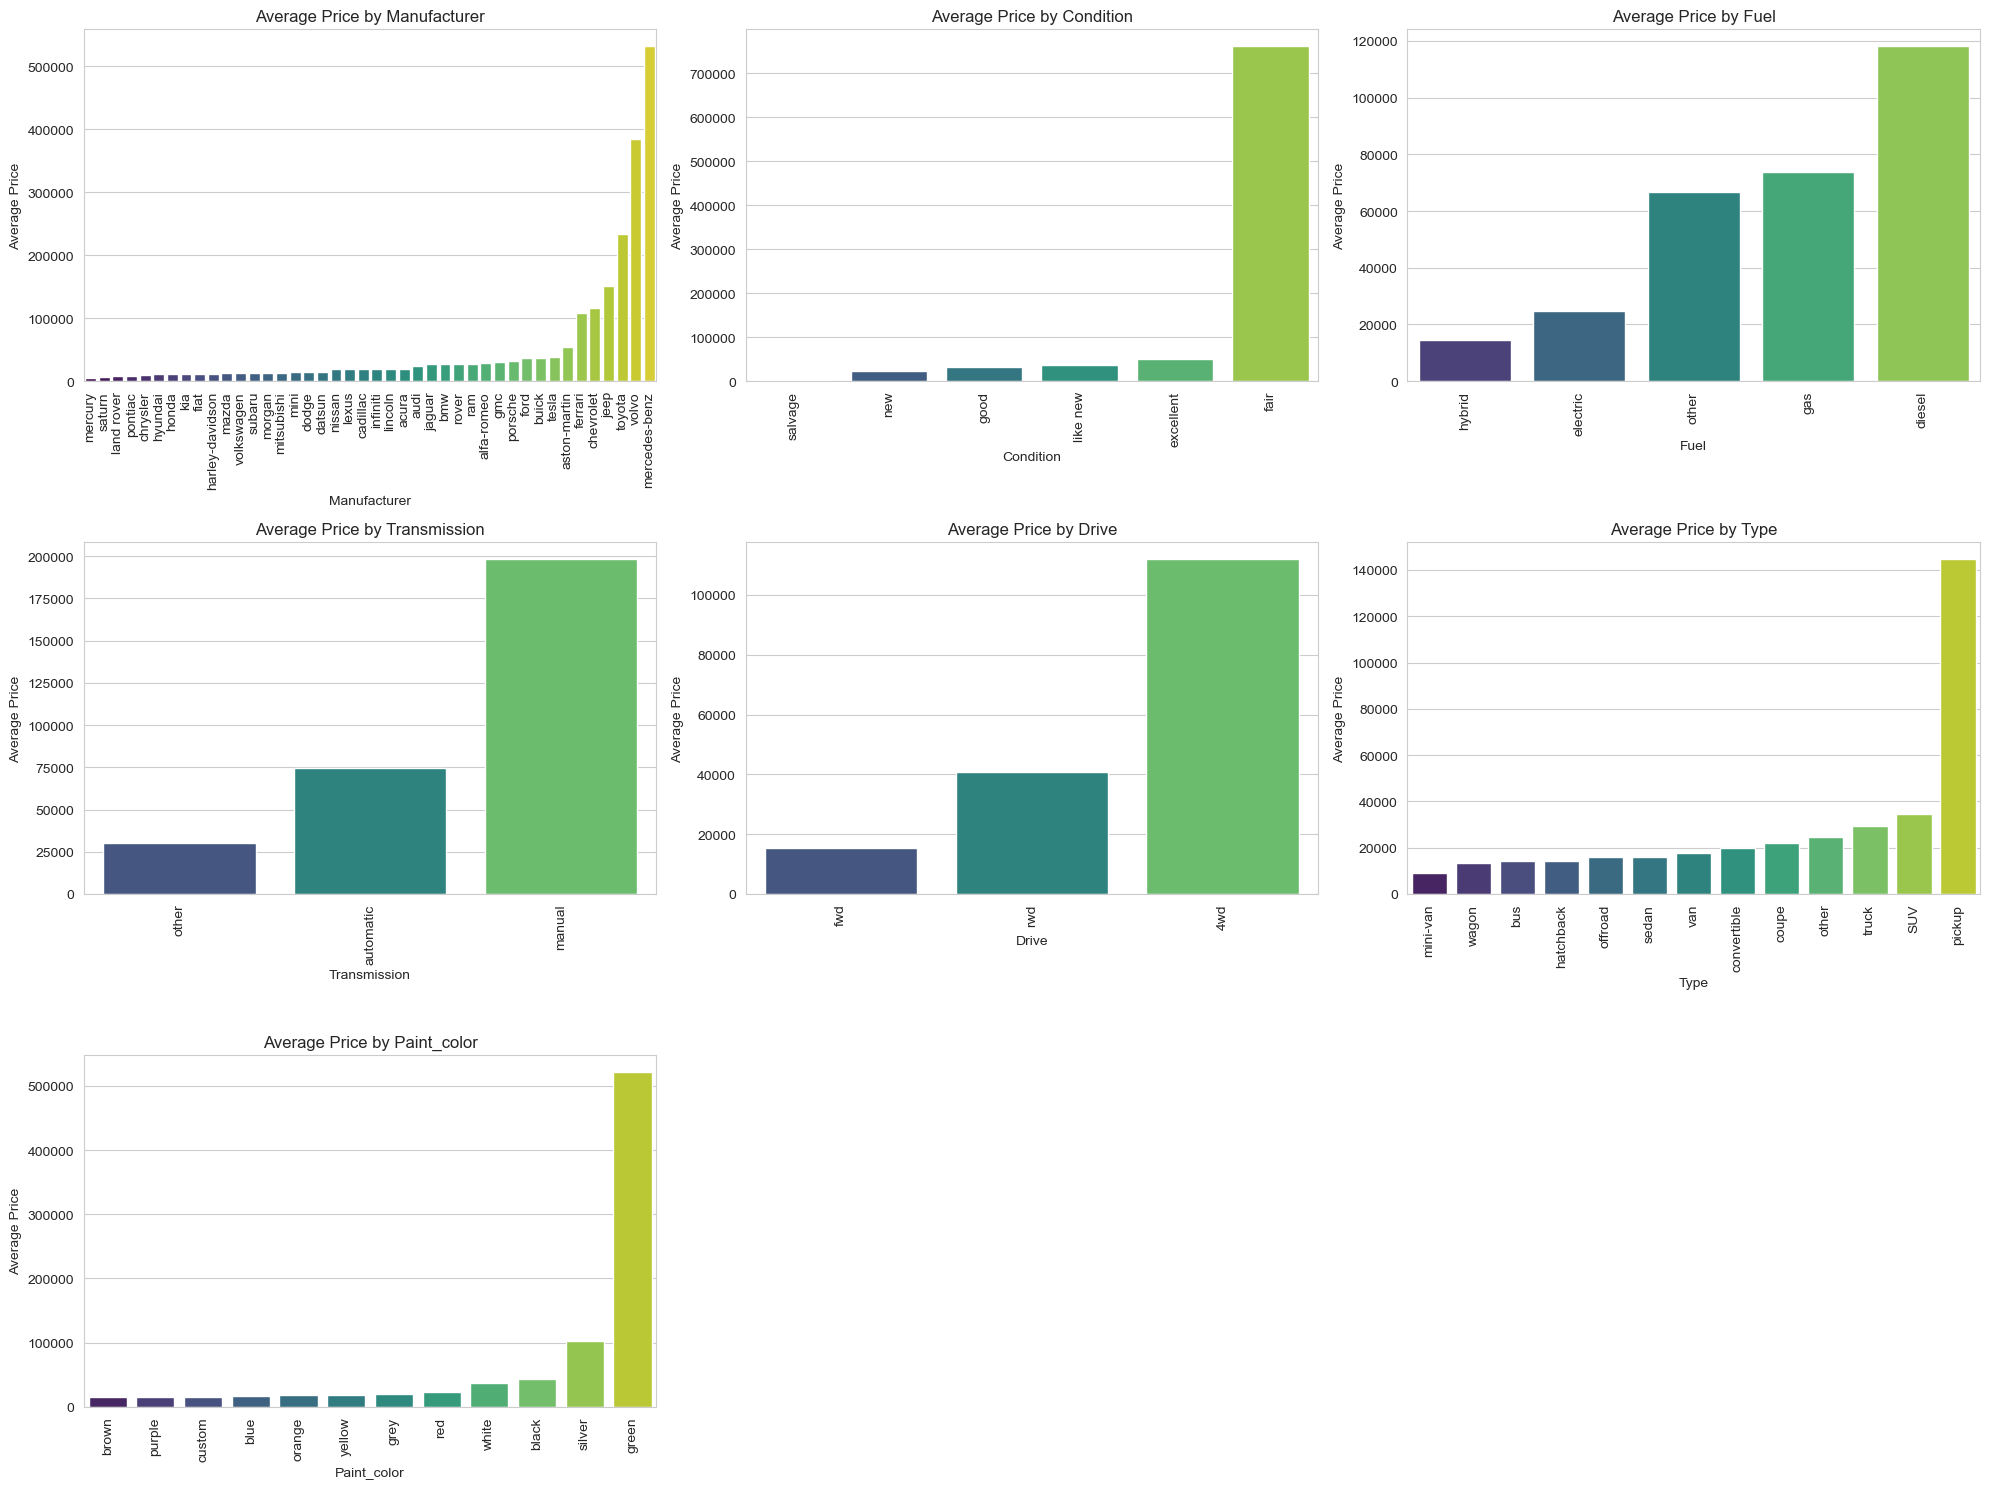

In [39]:
# distribution and impact on price for each categorical variable

# categorical variables to analyze
categorical_vars = ['manufacturer', 'condition', 'fuel', 'transmission', 'drive', 'type', 'paint_color']

# set up the figure for multiple plots
plt.figure(figsize=(20, 15))

# loop through each categorical variable
for i, var in enumerate(categorical_vars, 1):
    plt.subplot(3, 3, i)
    # calculate the average price for each category
    avg_price = data.groupby(var)['price'].mean().sort_values()
    
    # plot the average price for each category
    sns.barplot(x=avg_price.index, y=avg_price.values, palette='viridis')
    plt.title(f'Average Price by {var.capitalize()}')
    plt.xlabel(var.capitalize())
    plt.ylabel('Average Price')
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

Manufacturer: certain manufacturers, such as luxury brands, tend to have higher average prices. This indicates that the brand significantly impacts used car pricing.

Condition: as expected, cars in better condition (e.g., “excellent”, “like new”) generally have higher prices compared to those in “fair” or “salvage” conditions.

Fuel: hybrid and electric cars tend to have higher prices than gasoline or diesel cars, reflecting consumer preference for fuel efficiency or eco-friendliness.

Transmission: cars with automatic transmission tend to have slightly higher average prices than manual ones, possibly due to consumer preference or market demand.

Drive: all-wheel drive (AWD) and four-wheel drive (4WD) vehicles generally have higher prices compared to front-wheel drive (FWD), which may reflect their higher utility and desirability in certain regions.

Type: certain types, such as SUVs and trucks, tend to have higher average prices compared to sedans or coupes, indicating a demand for larger vehicles.

Paint Color: green colored cars have significantly higher average price. Might be special edition or limited production.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

First, I will remove all the rows where price is zero, as such records are likely errors.


In [40]:
data = data[data['price'] > 0]

Now, I'd like to handle missing values.

Size (71.77% missing): Drop this column. With over 70% missing data, it may not provide significant value to the analysis, and filling it would likely introduce too much noise.

Cylinders (41.62% missing): Fill with “unknown”. This column is important for understanding the car’s engine.

Condition (40.79% missing): Fill with “unknown”. The condition is a crucial factor affecting price.

VIN (37.73% missing): Drop this column. VIN is generally unique to each vehicle and not directly useful for predicting price or understanding consumer preferences.

Drive (30.59% missing): Fill with “unknown”. The drive type affects vehicle performance and price.

Paint Color (30.50% missing): Fill with “unknown”.

Type (21.75% missing): Fill with “unknown”. Vehicle type is an important factor.

Manufacturer (4.13% missing): Fill with “unknown”.

Title Status (1.93% missing): Fill with “unknown”.

Model (1.24% missing): Fill with “unknown”.

Odometer (1.03% missing): Fill with median. Mileage is a numerical, and it’s crucial for determining the car’s wear and tear.

Fuel (0.71% missing): Fill with “unknown”.

Transmission (0.60% missing): Fill with “unknown”.

Year (0.28% missing): Fill with median. The year of manufacture is a key numerical feature.

I will also apply logarithmic transformation to price due to skewness, generate polynomial features and do scaling for numerical data, use OneHotEncoder for categorical data. 

In [41]:
# drop columns
data = data.drop(columns=['size', 'VIN'])

# define numerical and categorical columns
numerical_cols = ['year', 'odometer']
categorical_cols = ['manufacturer', 'condition', 'cylinders', 'fuel', 'title_status', 
                    'transmission', 'drive', 'type', 'paint_color']

# apply logarithmic transformation to price
data['price_log'] = data['price'].apply(lambda x: np.log(x + 1))

# prepare transformers for the pipeline
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# apply transformations to respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

# splitting data into features and target
X = data.drop(['price', 'price_log'], axis=1)
y = data['price_log']

# Applying transformations
X = preprocessor.fit_transform(X)

In [42]:
# get feature names from polynomial features
poly_feature_names = preprocessor.named_transformers_['num']['poly'].get_feature_names_out(numerical_cols)

# get feature names from one-hot encoding
cat_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)

# combine all feature names
all_feature_names = np.concatenate([poly_feature_names, cat_feature_names])

# create a DataFrame with X and the feature names
X_df = pd.DataFrame(X.toarray(), columns=all_feature_names)
df = pd.concat([X_df, data['price']], axis=1)

# Display the DataFrame
print(df.head())

       year  odometer    year^2  year odometer  odometer^2  \
0  0.206709 -0.056796  0.206135      -0.056287   -0.024338   
1  0.206709 -0.056796  0.206135      -0.056287   -0.024338   
2  0.206709 -0.056796  0.206135      -0.056287   -0.024338   
3  0.206709 -0.056796  0.206135      -0.056287   -0.024338   
4  0.206709 -0.056796  0.206135      -0.056287   -0.024338   

   manufacturer_acura  manufacturer_alfa-romeo  manufacturer_aston-martin  \
0                 0.0                      0.0                        0.0   
1                 0.0                      0.0                        0.0   
2                 0.0                      0.0                        0.0   
3                 0.0                      0.0                        0.0   
4                 0.0                      0.0                        0.0   

   manufacturer_audi  manufacturer_bmw  ...  paint_color_green  \
0                0.0               0.0  ...                0.0   
1                0.0            

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [43]:
# define models and hyperparameters
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor()
}

param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {
        'alpha': [0.1, 1.0, 10.0, 100.0]
    },
    'Lasso Regression': {
        'alpha': [0.1, 1.0, 10.0, 100.0]
    },
    'Decision Tree': {
        'max_depth': [5, 10, 20, None],
        'min_samples_split': [2, 5, 10]
    }
}

In [44]:
# grid Search with cross-validation
best_models = {}
cv_results = {}

for model_name, model in models.items():
    print(f"GridSearchCV for {model_name}...")
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    grid_search.fit(X, y)
    best_models[model_name] = grid_search.best_estimator_
    cv_results[model_name] = grid_search.best_score_
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best CV Score for {model_name}: {grid_search.best_score_}\n")

GridSearchCV for Linear Regression...
Best Parameters for Linear Regression: {}
Best CV Score for Linear Regression: -1.068025193906191

GridSearchCV for Ridge Regression...
Best Parameters for Ridge Regression: {'alpha': 0.1}
Best CV Score for Ridge Regression: -1.0680298074718306

GridSearchCV for Lasso Regression...
Best Parameters for Lasso Regression: {'alpha': 0.1}
Best CV Score for Lasso Regression: -1.4081770985316306

GridSearchCV for Decision Tree...
Best Parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 10}
Best CV Score for Decision Tree: -1.0667928646050542



### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Let's take a look at the results of modeling. First, we will translate a negative mean squared error in the log-transformed scale back to the original scale

In [45]:
# function to translate negative MSE in log scale to original scale
def translate_neg_mse_log_to_original_scale(neg_mse_log):
    mse_log = -neg_mse_log
    rmse_log = np.sqrt(mse_log)
    rmse_original_scale = np.exp(rmse_log) - 1
    return rmse_original_scale

# apply to cv_results
original_scale_rmse_cv_results = {model_name: translate_neg_mse_log_to_original_scale(neg_mse) 
                                  for model_name, neg_mse in cv_results.items()}

print("Translated RMSE values in the original scale:")
for model_name, original_rmse in original_scale_rmse_cv_results.items():
    print(f"{model_name}: RMSE (original scale) = {original_rmse:.4f}")

Translated RMSE values in the original scale:
Linear Regression: RMSE (original scale) = 1.8108
Ridge Regression: RMSE (original scale) = 1.8108
Lasso Regression: RMSE (original scale) = 2.2761
Decision Tree: RMSE (original scale) = 1.8091


We can see that Decision Tree performed the best, Linear and Ridge regressions are very close to the top, and Lasso showed the biggest error. 

In [46]:
best_decision_tree = best_models['Decision Tree']

# get feature importances
feature_importances = best_decision_tree.feature_importances_

# combine feature names with their importances
feature_names = np.concatenate([poly_feature_names, cat_feature_names])
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)


Let's look at the most important features.

In [47]:
# display top 10 important features
print("Top 10 Important Features:")
print(importance_df.head(10))

Top 10 Important Features:
                   Feature  Importance
2                   year^2    0.338697
1                 odometer    0.063008
58   cylinders_4 cylinders    0.060000
64             fuel_diesel    0.057193
4               odometer^2    0.053855
3            year odometer    0.050499
0                     year    0.040816
79      transmission_other    0.027239
55  cylinders_10 cylinders    0.026594
18       manufacturer_ford    0.023142


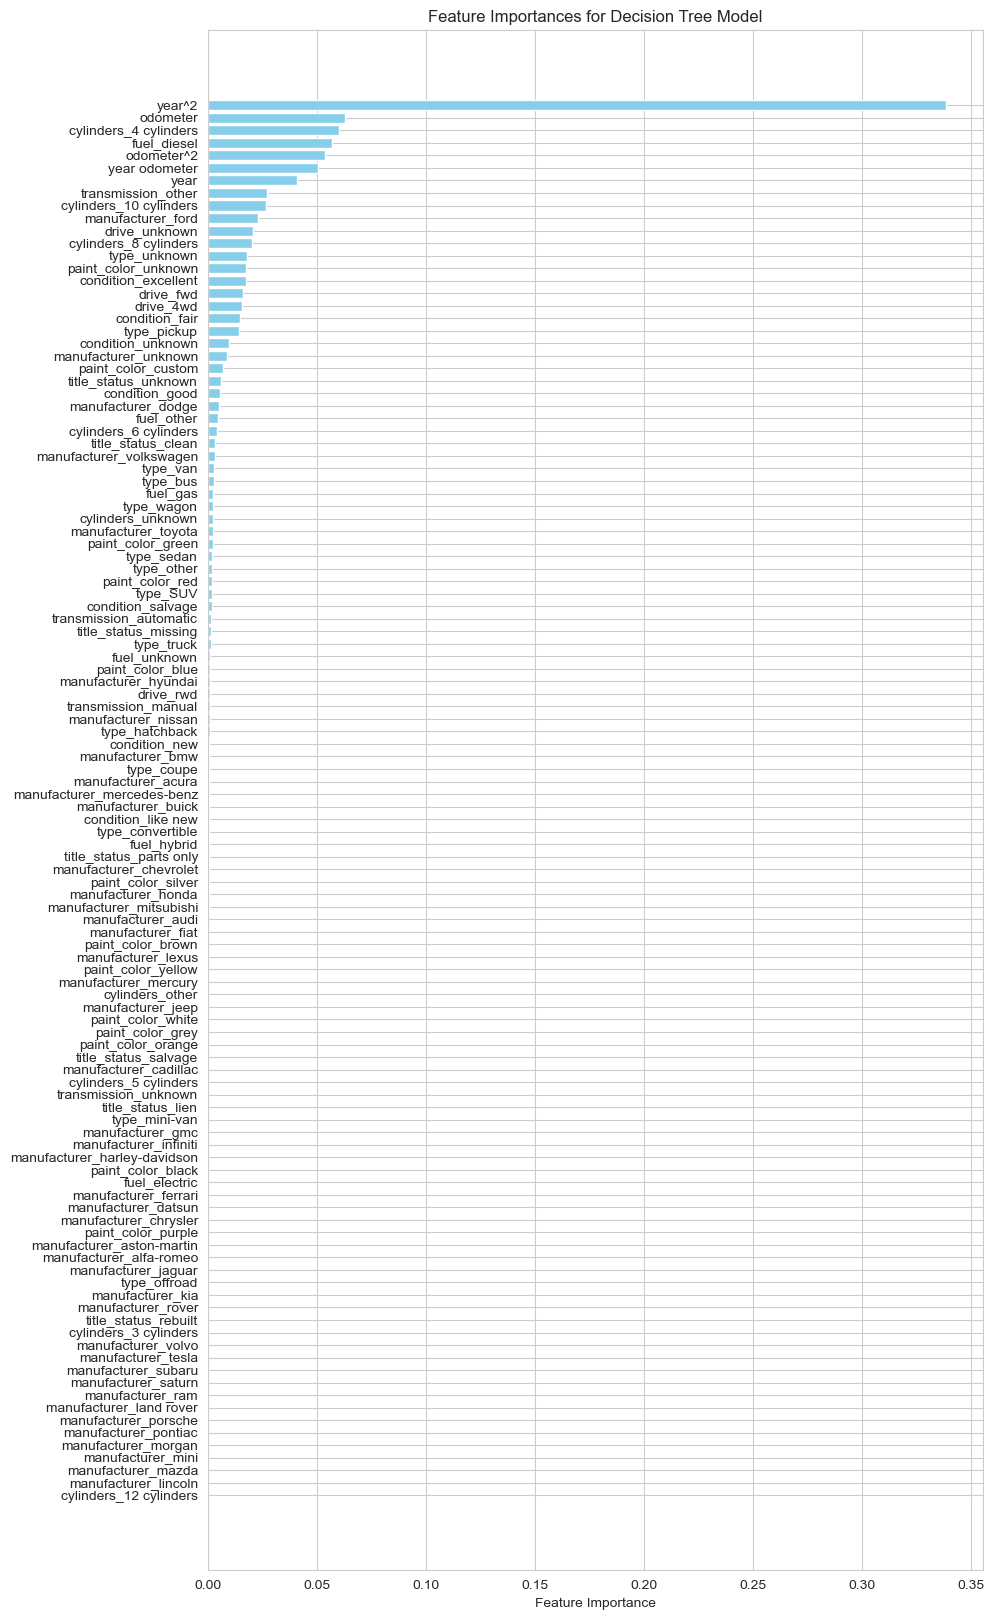

In [48]:
# plot feature importance
plt.figure(figsize=(10, 20))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances for Decision Tree Model')
plt.gca().invert_yaxis()
plt.show()

Next, I would like to review nodes of the decision tree.

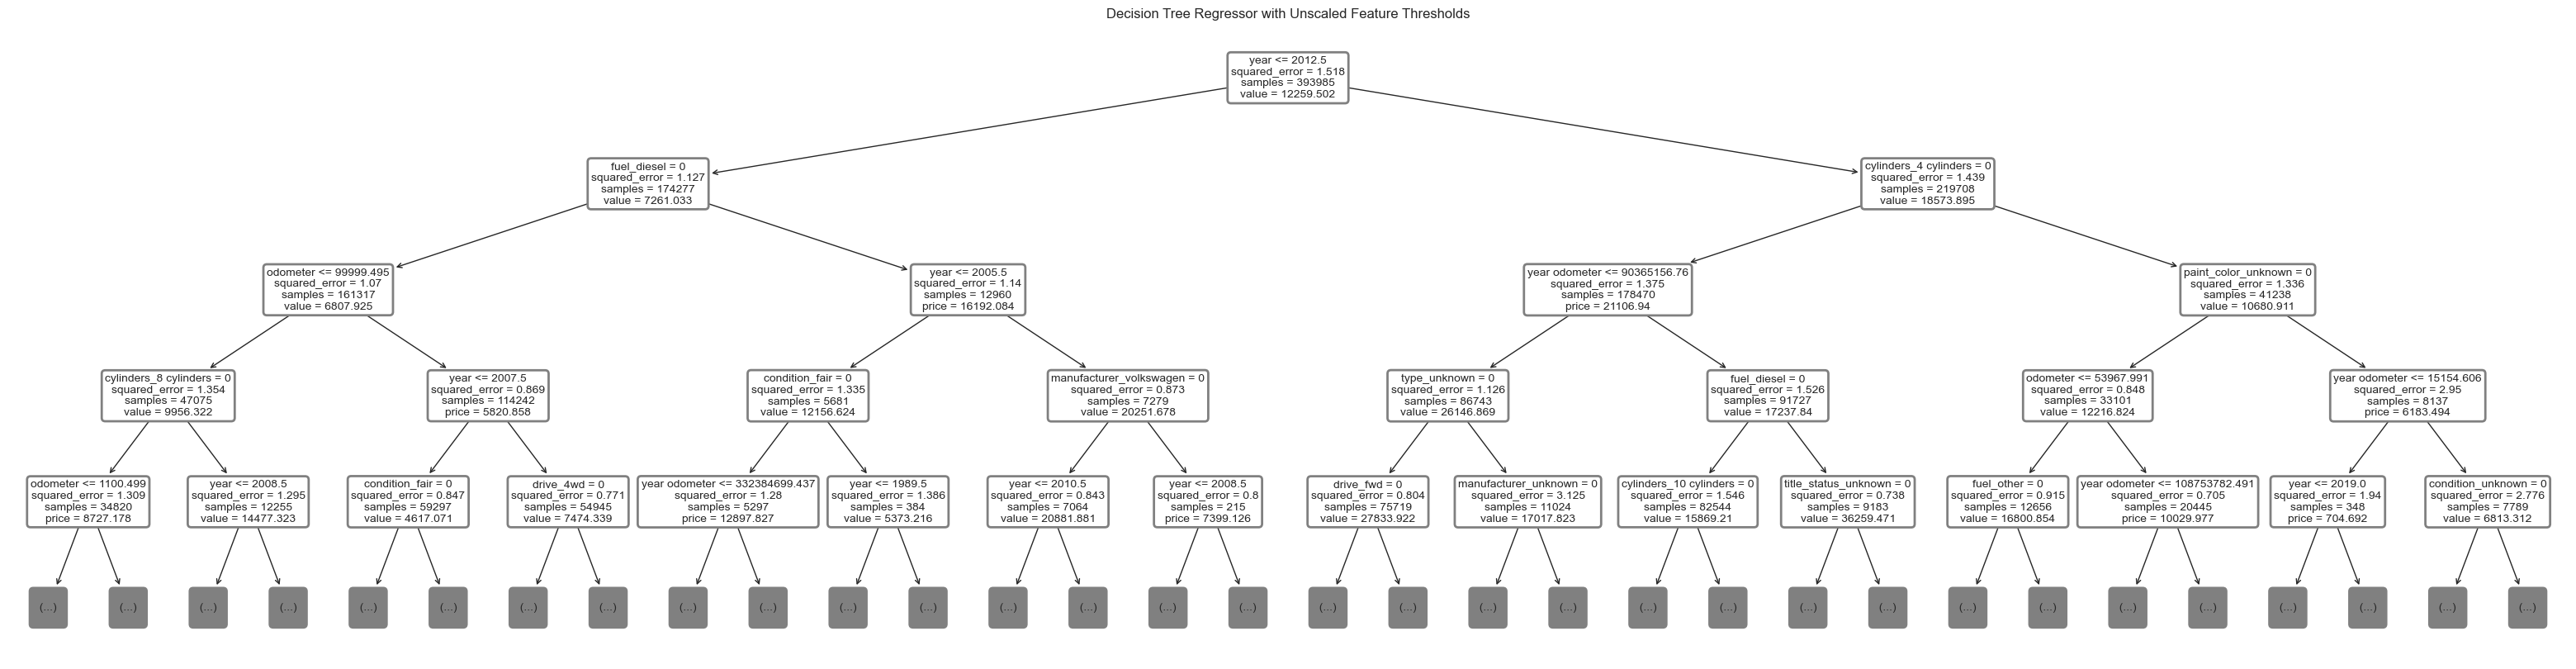

In [49]:
# access the numerical_transformer pipeline from the ColumnTransformer
numerical_transformer_pipeline = preprocessor.named_transformers_['num']

# retrieve the fitted StandardScaler instance from the numerical_transformer pipeline
scaler = numerical_transformer_pipeline.named_steps['scaler']

# define the features I want to inverse transform
features_to_inverse = ["year", "odometer", "year^2", "year odometer", "odometer^2"]

# get the full list of feature names after polynomial expansion
all_feature_names = numerical_transformer_pipeline.named_steps['poly'].get_feature_names_out(input_features=numerical_cols)
year_square_index = np.where(all_feature_names == "year^2")[0][0]
odometer_square_index = np.where(all_feature_names == "odometer^2")[0][0]

# identify the indices of the features to inverse transform
indices_to_inverse = [np.where(all_feature_names == feature)[0][0] for feature in features_to_inverse]

# access the tree structure
tree_ = best_decision_tree.tree_

# inverse transform the thresholds for the selected features
for i in range(tree_.node_count):
    tree_.value[i] = np.exp(tree_.value[i]) - 1
    feature_index = tree_.feature[i]
    if feature_index in indices_to_inverse:
        threshold = tree_.threshold[i]
        
        # create a dummy array to hold the threshold value for inverse transform
        dummy_array = np.zeros((1, len(all_feature_names)))
        dummy_array[0, feature_index] = threshold
        
        # apply inverse transform to get the original scale value
        unscaled_threshold = scaler.inverse_transform(dummy_array)[0, feature_index]
        
        # update the tree with the unscaled threshold
        tree_.threshold[i] = unscaled_threshold
        if feature_index in [year_square_index, odometer_square_index] :
            tree_.threshold[i] = np.sqrt(tree_.threshold[i])

# plot the tree with unscaled feature labels
plt.figure(figsize=(40, 10))
plot_tree(best_decision_tree, feature_names=feature_names, filled=True, max_depth=4, fontsize=10)
plt.title("Decision Tree Regressor with Unscaled Feature Thresholds")
# Replace "value" with "price" in the text labels
for text in plt.gca().get_children():
    if isinstance(text, plt.Text):
        label = text.get_text()
        if "value" in label:
            text.set_text(label.replace("value", "price"))
        if "year^2" in label:
            text.set_text(label.replace("year^2", "year"))
        if "odometer^2" in label:
            text.set_text(label.replace("odometer^2", "odometer"))
        if "<= 0.5" in label:
            text.set_text(label.replace("<= 0.5", "= 0"))
          
ax = plt.gca()

# iterate through all text objects to find the boxes around nodes
for text in ax.get_children():
    if isinstance(text, plt.Text):
        bbox = text.get_bbox_patch()
        if bbox is not None:
            bbox.set_edgecolor('grey')
            bbox.set_linewidth(2)
            bbox.set_boxstyle("round,pad=0.3")


plt.show()

The leaves of the decision tree represent different groups of cars with distinct price averages and squared errors, showing how the decision tree model partitions the dataset into subsets with different average prices based on the attributes:
- The first split in the decision tree is based on the year of the car (year <= 2012.5). This indicates that the year of manufacture is the most significant factor in determining the price of a used car. Cars manufactured after 2012 generally have higher prices.
- Odometer Reading. For cars with a manufacture year older than 2012, the odometer reading (odometer <= 99,995) further segments the prices. Lower mileage vehicles within this group tend to have higher prices.
- Condition. Another significant factor is the car’s condition (condition_fair = 0), suggesting that cars in better condition fetch higher prices.
- Number of cylinders. The number of cylinders is a notable split for newer cars, particularly distinguishing between cars with 4 cylinders and others.
- Fuel type and other attributes. Further down the tree, attributes like fuel, drive, and paint color come into play, influencing the final pricing within more narrowly defined groups.

In [50]:
# prepare data for plotting a report
# fill missing values in numerical columns with median
for col in numerical_cols:
    data[col] = data[col].fillna(data[col].median())

# fill missing values in categorical columns with 'unknown'
for col in categorical_cols:
    data[col] = data[col].fillna('unknown')

data.tail()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,price_log
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,fwd,sedan,unknown,wy,10.068621
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,unknown,gas,12029.0,clean,other,fwd,sedan,red,wy,10.328461
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,unknown,diesel,4174.0,clean,other,unknown,hatchback,white,wy,10.462846
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,fwd,sedan,silver,wy,10.274741
426879,7301591129,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,unknown,gas,22716.0,clean,other,rwd,coupe,unknown,wy,10.328461


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

This report provides insights into the primary factors influencing used car prices based on an analysis of a decision tree model. 

<h2 style="text-align:center;">Key Findings</h2>

<h3 style="text-align:center;">1. Year of Manufacture</h3>

The most significant factor affecting used car prices is the year of manufacture. Vehicles manufactured after 2012 are generally priced higher than older models.

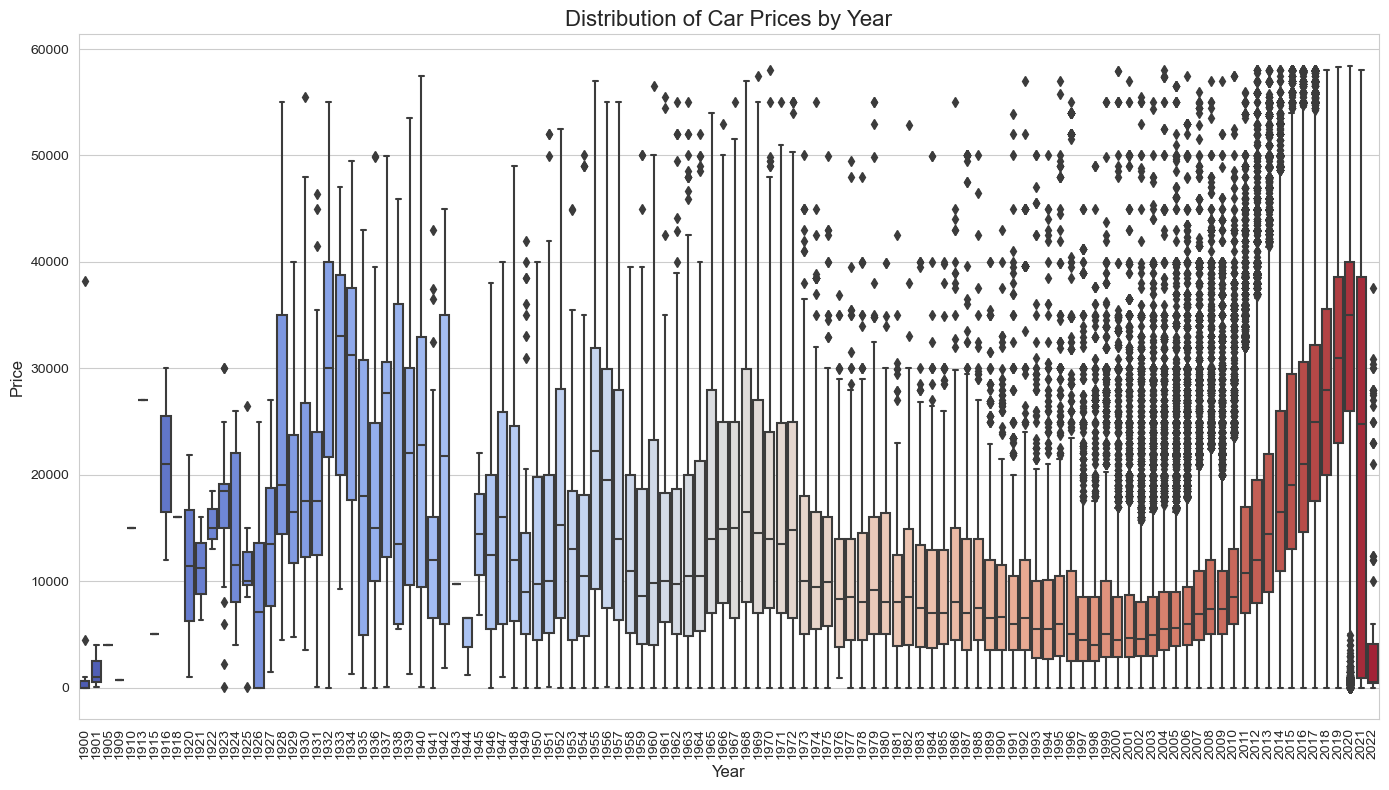

In [62]:
# calculate the IQR
Q1_price = data['price'].quantile(0.25)
Q3_price = data['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price

# remove outliers
data['year'] = data['year'].astype(int)
data_filtered_price = data[(data['price'] >= Q1_price - 1.5*IQR_price) & (data['price'] <= Q3_price + 1.5*IQR_price)]

# boxplot using seaborn
plt.figure(figsize=(14, 8))
sns.boxplot(x='year', y='price', data=data_filtered_price, palette='coolwarm')
plt.title('Distribution of Car Prices by Year', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.show()

<h3 style="text-align:center;">2. Odometer Reading</h3>

The odometer reading, or mileage, is another critical factor. Cars with lower mileage are typically priced higher, reflecting their lesser wear and tear.

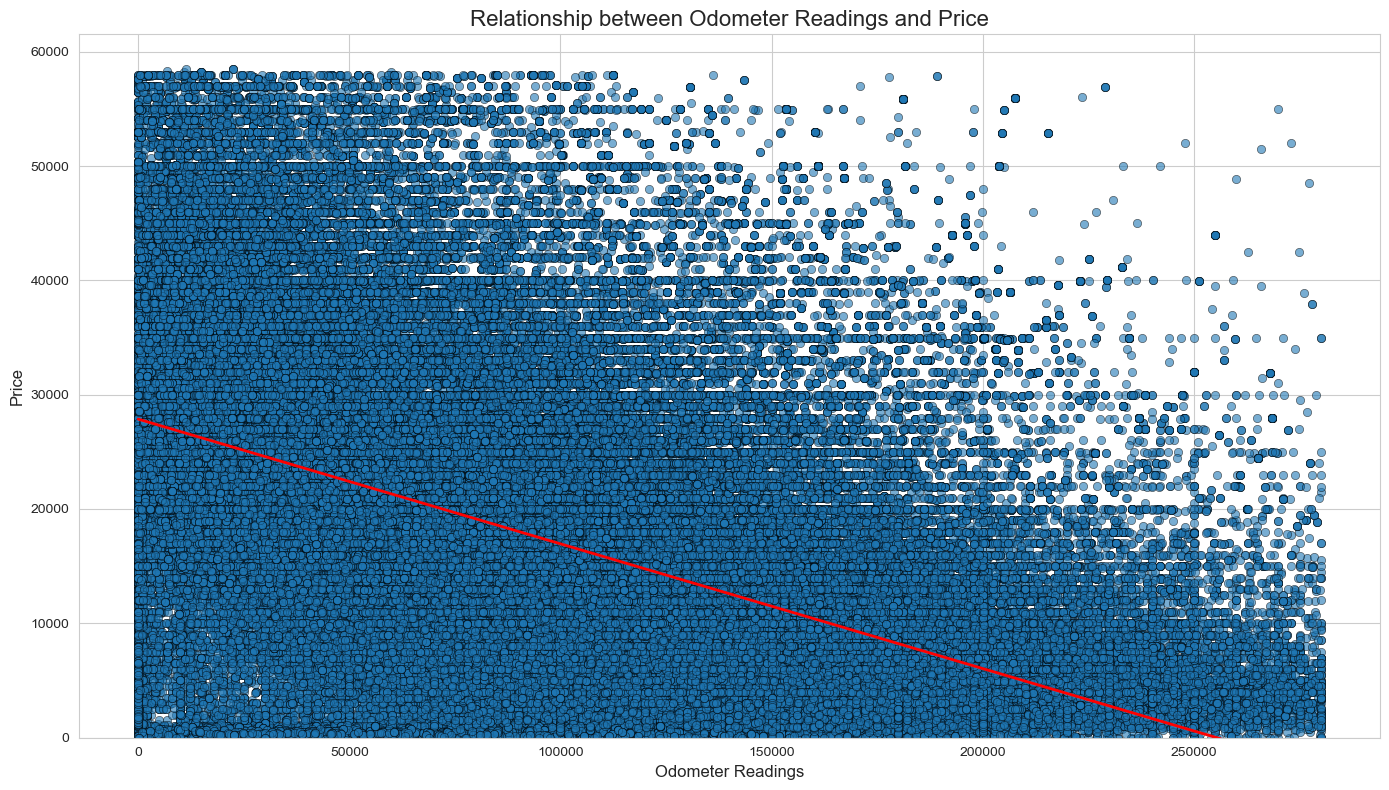

In [63]:
# calculate the IQR for odometer
Q1_odometer = data['odometer'].quantile(0.25)
Q3_odometer = data['odometer'].quantile(0.75)
IQR_odometer = Q3_odometer - Q1_odometer

# remove outliers
data_filtered_price_odometer = data[(data['price'] >= Q1_price - 1.5*IQR_price) & 
                     (data['price'] <= Q3_price + 1.5*IQR_price) & 
                     (data['odometer'] >= Q1_odometer - 1.5*IQR_odometer) & 
                     (data['odometer'] <= Q3_odometer + 1.5*IQR_odometer)]

# scatter plot with regression line
plt.figure(figsize=(14, 8))
sns.scatterplot(x='odometer', y='price', data=data_filtered_price_odometer, alpha=0.6, color='#1f77b4', edgecolor='black')
sns.regplot(x='odometer', y='price', data=data_filtered_price_odometer, scatter=False, color='red', line_kws={"linewidth":2})
plt.title('Relationship between Odometer Readings and Price', fontsize=16)
plt.xlabel('Odometer Readings', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.ylim(bottom=0)  # Remove negative values on Y-axis
plt.grid(True)
plt.tight_layout()
plt.show()

<h3 style="text-align:center;">3. Condition of the Car</h3>

Vehicle condition significantly impacts pricing. Cars in “excellent” or “good” condition fetch higher prices compared to those in “fair” or lower conditions.

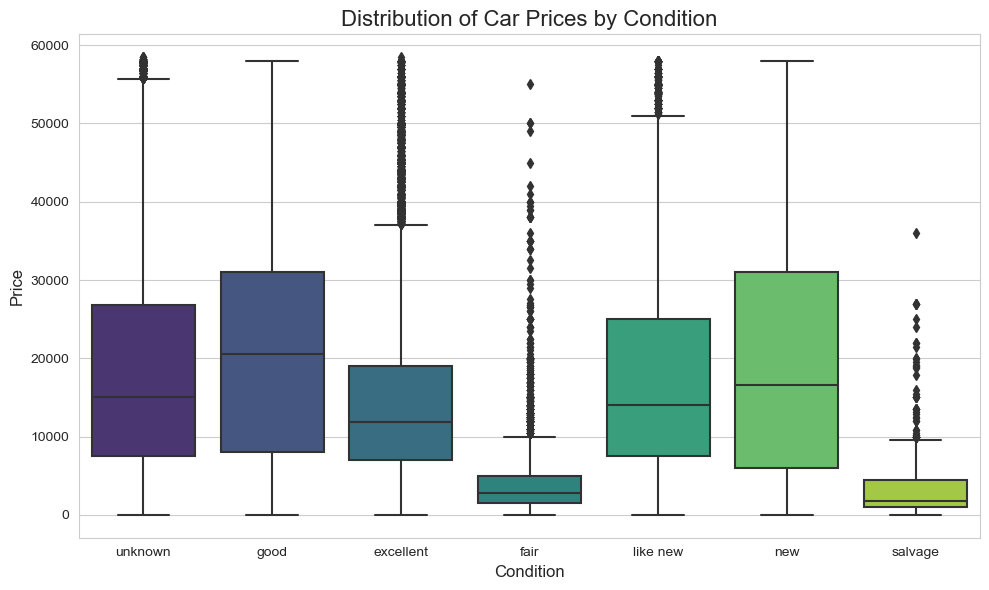

In [64]:
# boxplot of car prices by condition
plt.figure(figsize=(10, 6))
sns.boxplot(x='condition', y='price', data=data_filtered_price, palette='viridis')
plt.title('Distribution of Car Prices by Condition', fontsize=16)
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.tight_layout()
plt.show()

<h3 style="text-align:center;">4. Fuel Type and Cylinders</h3>

Cars with different fuel types and engine configurations (number of cylinders) show varied pricing. Diesel vehicles and those with more cylinders generally have different pricing patterns, influenced by fuel economy, engine performance, and market demand.

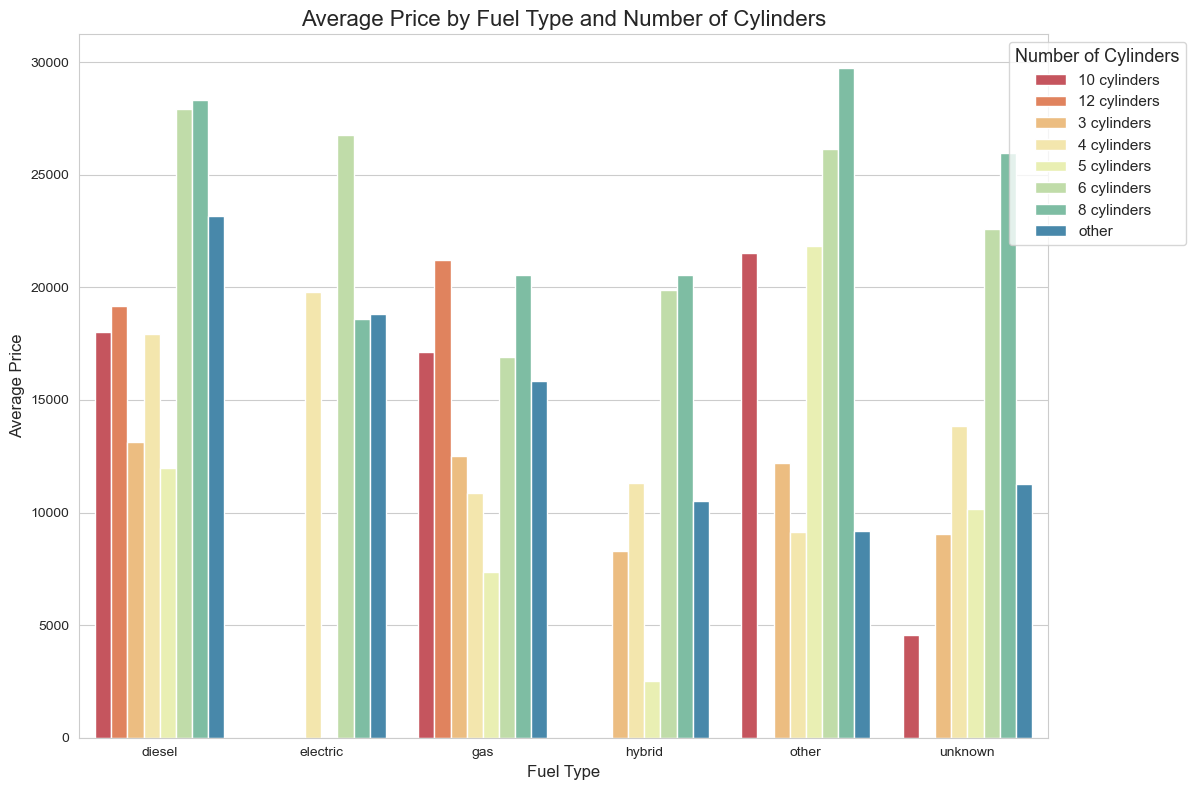

In [70]:
data_filtered_grouped = data_filtered_price[(data_filtered_price['cylinders'] != 'unknown')]

# calculate the average price for each fuel type and number of cylinders after filtering
data_grouped = data_filtered_grouped.groupby(['fuel', 'cylinders'])['price'].mean().reset_index()

# bar plot of avg price by fuel and number of cylinders
plt.figure(figsize=(12, 8))
sns.barplot(x='fuel', y='price', hue='cylinders', data=data_grouped, palette='Spectral', errorbar=None)
plt.title('Average Price by Fuel Type and Number of Cylinders', fontsize=16)
plt.xlabel('Fuel Type', fontsize=12)
plt.ylabel('Average Price', fontsize=12)
plt.legend(title='Number of Cylinders', title_fontsize='13', fontsize='11', loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()